In [61]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch import optim

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [62]:
train_data = MNIST(
    root="/data/DataSet/",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(
            size=(32, 32)
        ),
        transforms.Normalize(
            mean=(0.5),
            std=(0.5)
        )
    ])
)
test_data = MNIST(
    root="/data/DataSet/",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(
            size=(32, 32)
        ),
        transforms.Normalize(
            mean=(0.5),
            std=(0.5)
        )
    ])
)
train_data[0][0].shape

torch.Size([1, 32, 32])

In [63]:
labels_map = train_data.class_to_idx
labels_map = dict(zip(labels_map.values(), labels_map.keys()))

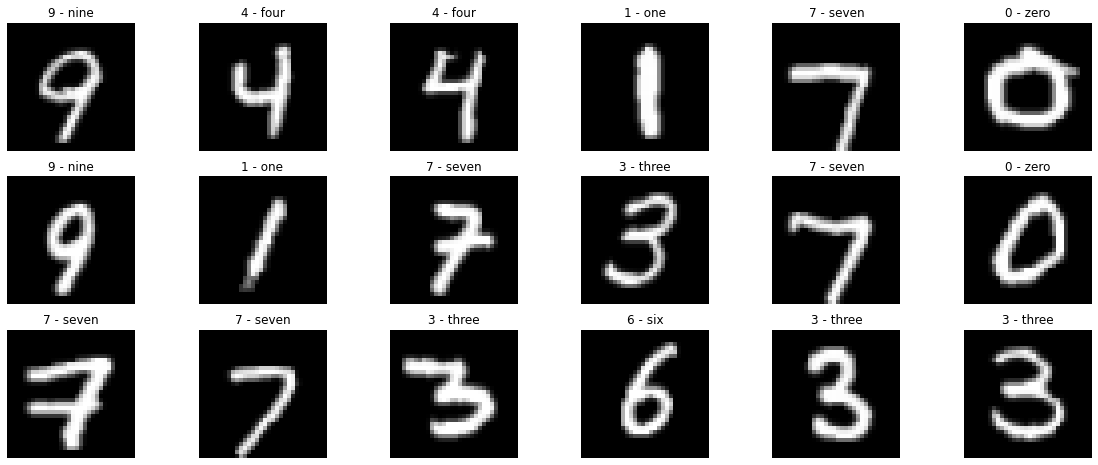

In [64]:
fig = plt.figure(figsize=(20, 8))

col = 6
row = 3

for i in range(1, col * row + 1):
    random_img_number = np.random.randint(len(train_data))
    random_img = train_data[random_img_number][0][0]

    fig.add_subplot(row, col, i)
    plt.title(labels_map[train_data[random_img_number][1]])
    plt.axis('off')
    plt.imshow(random_img, cmap='gray')

plt.show()

In [71]:
from torch import normal

class linear(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        normalize: bool = True,
        activation: bool = True,
        dropout: float = 0.0
        ):

        super(linear, self).__init__()

        layers = [
            nn.Linear(
                in_features=in_features,
                out_features=out_features
            )
        ]

        if normalize:
            layers.append(
                nn.BatchNorm2d(
                    num_features=out_features
                )
            )
        
        if activation:
            layers.append(
                nn.ReLU()
            )

        if dropout:
            layers.append(
                nn.Dropout(
                    p=dropout
                )
            )

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    
class conv(nn.Module):
    def __init__(
        self, 
        in_channels: int, 
        out_channels: int, 
        kernel_size: int = 5, 
        stride: int = 1, 
        padding: int = 0,
        normalize: bool = True,
        activation: bool = True,
        dropout: float = 0.0
        ):

        super(conv, self).__init__()

        layers = [
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding
            )
        ]
        
        if normalize:
            layers.append(
                nn.BatchNorm2d(
                    num_features=out_channels
                )
            )
        
        if activation:
            layers.append(
                nn.ReLU()
            )

        if dropout:
            layers.append(
                nn.Dropout(
                    p=dropout
                )
            )
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)
        
class LeNet(nn.Module):
    def __init__(self, in_channels: int = 1, out_channels: int = 1):
        super(LeNet, self).__init__()
        
        # 32 -> 28
        self.layer1 = conv(
            in_channels=1,
            out_channels=6
        )

        # 28 -> 14
        self.layer2 = nn.MaxPool2d(2)
        
        # 14 -> 10
        self.layer3 = conv(
            in_channels=6,
            out_channels=16
        )
        
        # 10 -> 5
        self.layer4 = nn.MaxPool2d(2)

        # 400 -> 120
        self.layer5 = linear(
            in_features=400,
            out_features=120,
        )

        self.layer6 = linear(
            in_features=120,
            out_features=84
        )

        self.final = nn.Sequential(
            nn.Linear(
                in_features=84,
                out_features=10
            ),
            nn.Softmax(
                dim=1
            )
        )
    
    def forward(self, x):
        print(x.shape)
        x = self.layer1(x)
        print(x.shape)
        x = self.layer2(x)
        print(x.shape)
        x = self.layer3(x)
        print(x.shape)
        x = self.layer4(x)
        print(x.shape)
        x = x.view(-1, 16*5*5)
        print(x.shape)
        x = self.layer5(x)
        x = self.layer6(x)
        
        return self.final(x)

In [66]:
batch_size = 516

train_loader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

In [76]:
a = torch.rand(
    size=(batch_size, 1, 32, 32)
    )

a = a.view(-1, 1*32*32)

print(a.shape)
nn.Linear(400, 120)(a)

torch.Size([516, 1024])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (516x1024 and 400x120)

In [72]:
num_epochs = 200

model = LeNet()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

writer = SummaryWriter("Tensorboard/")
for epoch in range(1, num_epochs + 1):

    model.train()
    batch_loss = 0.0

    for count, (imgs, labels) in enumerate(train_loader, start=1):
        x, y = imgs.to(device), labels.to(device)

        y_hat = model(x) 
        break
    break

torch.Size([516, 1, 32, 32])
torch.Size([516, 6, 28, 28])
torch.Size([516, 6, 14, 14])
torch.Size([516, 16, 10, 10])
torch.Size([516, 16, 5, 5])
torch.Size([516, 400])


ValueError: expected 4D input (got 2D input)